# Autoregressive Moving Average (ARMA) Models

<a href="https://colab.research.google.com/github/febse/ts2025/blob/main/04-ARMA-Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Class Version In Colab"/>Class Version</a>

## The Purely Random Process

A purely random process (also known as a white noise process) is a stochastic process where the value at time $t$, denoted as $e_t$ is uncorrelated with its past values and has a constant mean and variance.

$$
E(e_t) = 0, \\
Var(e_t) = E(e_t^2) = \sigma^2 \\ 
Cov(e_t, e_{t-k}) = E(e_t e_{t-k}) = 0 \text{ for } k \neq 0
$$

It is a stationary process since its statistical properties (level, fluctuations and autocorrelation) do not change over time. Therefore it is a **stationary** process.




:::{#def-stationarity}

## Stationarity

A process is mean-stationary if its expected value does not change over time, i.e.

$$
E(x_t) = E(x_{t - 1}) = E(x_{t - 2}) = \ldots = E(x_{t + 1}) = \ldots 
$$

If the variance of a process is constant over time, we say that the process is **variance-stationary**.

$$
Var(x_t) = Var(x_{t - 1}) = Var(x_{t - 2}) = \ldots = Var(x_{t + 1}) = \ldots
$$

In case that the auto-covariances are constant over time, we say that the process is **covariance-stationary**.

$$
Cov(x_{t}, x_{t-k}) = Cov(x_{t-1}, x_{t-k-1}) = \ldots = Cov(x_{t+1}, x_{t+1-k}) = \ldots
$$

:::

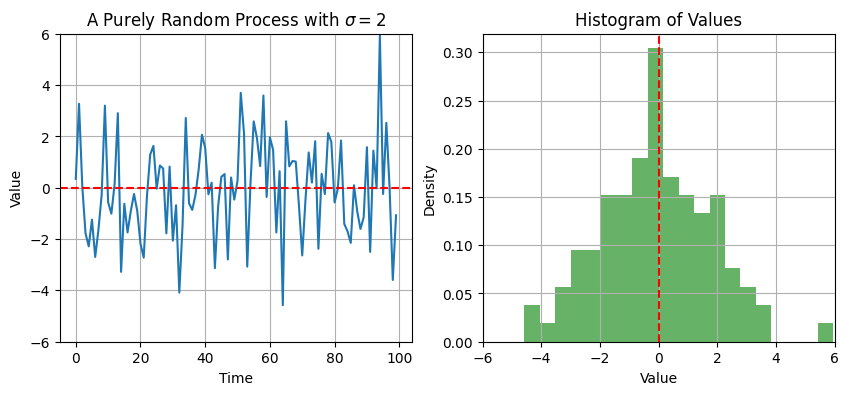

In [2]:
# A purely random process with a standard deviation of 1

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

np.random.seed(321)

sigma = 2
e = np.random.normal(loc = 0, scale=sigma, size=100)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(e)
ax[0].set_title(rf"A Purely Random Process with $\sigma={sigma}$")
ax[0].axhline(0, color='red', linestyle='--')
ax[0].set_ylim(-6, 6)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Value")
ax[0].grid()

ax[1].hist(e, bins=20, density=True, alpha=0.6, color='g')
ax[1].set_title("Histogram of Values")
ax[1].set_xlim(-6, 6)
ax[1].axvline(0, color='red', linestyle='--')
ax[1].set_xlabel("Value")
ax[1].set_ylabel("Density")
ax[1].grid()

## The Empirical Auto-correlation Function (ACF) 

The (empirical) auto-correlation function (ACF) measures the correlation between observations of a time series separated by various time lags.

The empirical auto-correlation at lag $k$ is defined as:

$$
\hat{\rho}(k) = \frac{\sum_{t=k+1}^{T} (y_t - \bar{y})(y_{t-k} - \bar{y})}{\sum_{t=1}^{T} (y_t - \bar{y})^2}
$$

where the numerator is the empirical covariance at lag $k$ and the denominator is the variance of the series.

The partial auto-correlation function (PACF) measures the correlation between observations of a time series separated by lag $k$, after removing the effects of all shorter lags (1 to $k-1$). We will come back to this later when we discuss AR processes.

Let's compute the ACF of the white noise process manually at first. For this purpose it is convenient to pack the values into a pandas DataFrame first.

In [3]:
import pandas as pd

df_e = pd.DataFrame(e, columns=["e"])
df_e.head()

,e
0,0.345039
1,3.270965
2,0.074673
3,-1.768299
4,-2.286385


In [4]:
# To compute the ACF, we need to compute the lags of e first. We will illustrate 
# this for the first 3 lags

df_e["e_lag1"] = df_e["e"].shift(1)
df_e["e_lag2"] = df_e["e"].shift(2)
df_e["e_lag3"] = df_e["e"].shift(3)

df_e.head()


,e,e_lag1,e_lag2,e_lag3
0,0.345039,NaN,NaN,NaN
1,3.270965,0.345039,NaN,NaN
2,0.074673,3.270965,0.345039,NaN
3,-1.768299,0.074673,3.270965,0.345039
4,-2.286385,-1.768299,0.074673,3.270965


In [5]:
# Now all we need to do is compute the correlation of e and e_lag1, e and e_lag2, etc.
# Before we do that, we need to remove the first 3 rows where the lags are not defined.

df_e = df_e.dropna()
df_e.head()

,e,e_lag1,e_lag2,e_lag3
3,-1.768299,0.074673,3.270965,0.345039
4,-2.286385,-1.768299,0.074673,3.270965
5,-1.242732,-2.286385,-1.768299,0.074673
6,-2.697299,-1.242732,-2.286385,-1.768299
7,-1.639462,-2.697299,-1.242732,-2.286385


In [6]:
np.corrcoef([df_e["e"], df_e["e_lag1"], df_e["e_lag2"], df_e["e_lag3"]])

array([[ 1.        ,  0.054418  ,  0.04607323, -0.1011791 ],
       [ 0.054418  ,  1.        ,  0.04617105,  0.04643615],
       [ 0.04607323,  0.04617105,  1.        ,  0.05034285],
       [-0.1011791 ,  0.04643615,  0.05034285,  1.        ]])

The first row of the output is the correlation between e and e_lag1, e and e_lag2, e and e_lag3.
This is what you see in the ACF plot below, where these auto-correlations are plotted as bars against the lags (on the x-axis).

$$
\begin{align*}
\hat{\rho}(1) & = 0.054 \\
\hat{\rho}(2) & = 0.046 \\
\hat{\rho}(3) & = -0.10 \\
\end{align*}
$$

For a purely random process, the empirical auto-correlations should be small and close to zero because the white noise process is uncorrelated (we have demanded that $Cov(e_t, e_{t-k}) = 0$ for all $k \neq 0$).

The blue ribbon around the x-axis shows a 95% confidence interval for the auto-correlations of a purely random process. Setting the `bartlett_confint=False` argument in the `plot_acf` shows a confidence interval based on the assumption that the process is white noise. For every lag, the empirical auto-correlation is expected to be within this interval 95% of the time if the process is white noise.

The boundaries of the confidence interval are computed as:

$$
\pm 1.96 \sqrt{\frac{1}{T}}
$$


Text(0.5, 1.0, 'Auto-correlation of White Noise')

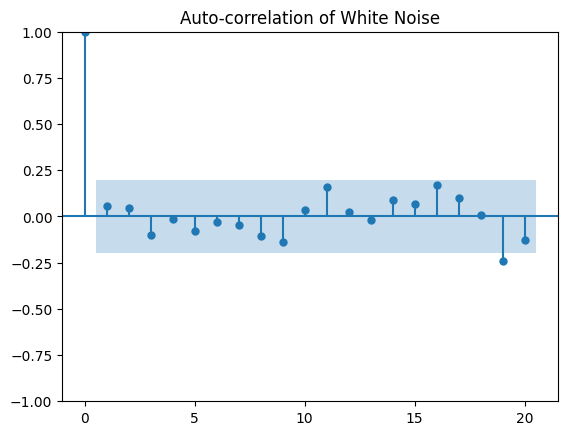

In [7]:
# Auto-correlation

plot_acf(e, lags=20, bartlett_confint=False)
plt.title("Auto-correlation of White Noise")


## Autoregressive Processes (AR)

An autoregressive process of order $p$, denoted as AR($p$), is a stochastic process where the current value of the series is expressed as a linear combination of its previous $p$ values and a random error term.

$$
x_t = \phi_0 + \phi_1 x_{t-1} + \phi_2 x_{t-2} + ... + \phi_p x_{t-p} + e_t
$$

where:
- $x_t$ is the value of the series at time $t$,
- $\phi_1, \phi_2, ..., \phi_p$ are the parameters of the model,
- $e_t$ is a white noise error term with mean zero and constant variance $\sigma^2$.


In the following we want to study the properties of autoregressive processes. Our primary interest is in the expected value, variance and auto-correlation structure of the processes, because when selecting a model for an observed time series we can match the features in the data (observed mean, variance, auto-correlations) with the expected properties of a model.

## Rules for Computing Expectations

When we derive the statistical properties of a process, we rely on the following rules for computing expectations:

If $X$ and $Y$ are random variables and $c$ is a constant (not random), then the following rules apply:

$$
E(X + Y) = E(X) + E(Y)
$$

This means that we can write the expected value of a sum of random variables as the sum of the expected values of the individual variables.

$$
E(cX) = cE(X)
$$

The second rule says that we can factor out constants from the expected value.

$$
E(c) = c
$$

The third rule says that the expected value of a constant is the constant itself.

$$
Var(X) = E(X - E(X))^2 = E(X^2) - E(X)^2
$$

This rule (we will use it without proof) allows us to compute the variance of a random variable as the expected value of the square of the random variable minus the square of its expected value. This is especially useful when the variable has a zero mean (expected value) because then the formula reduces to:

$$
Var(X) = E(X^2)
$$

For the covariance of two random variables $X$ and $Y$, we have:

$$
Cov(X, Y) = E((X - E(X))(Y - E(Y))) = E(XY) - E(X)E(Y)
$$

This rule allows us to compute the covariance of two random variables as the expected value of the product of the two random variables minus the product of their expected values.

Before we proceed it helps to rewrite the properties of the purely random process in terms of expectations. Because the expected value of the process is zero we can apply the rules above to simplify the expressions for the variance and covariances of the process:

$$
\begin{align*}
E(e_t) & = 0 \\
Var(e_t) = E(e_t^2) & = \sigma^2 \\
Cov(e_t, e_{t-k}) = E(e_t e_{t-k}) & = 0 \text{ for } k \neq 0
\end{align*}
$$










## The AR(1) Process

The simplest autoregressive process is the AR(1) process, where the current value depends only on the value that precedes it.

$$
x_t = \phi_0 + \phi_1 x_{t-1} + e_t
$$

In the discussion about difference equations, we saw that the AR(1) is stable if $|\phi| < 1$. What about the statistical properties of the AR(1) process?

In the following we will derive the properties of **stationary** AR processes where the mean, variance and covariances do not change over time. Therefore, we can introduce a more compact notation:

We will write $\mu$ for the mean of the process, i.e. 

$$
\begin{align*}
\mu & = E(x_t),  \forall t \\
\gamma(0) & = Var(x_t), \forall t \\
\gamma(1) & = Cov(x_{t - k}, x_{t -k - 1}), \forall t, k \\
\gamma(2) & = Cov(x_{t - k}, x_{t -k - 2}), \forall t, k \\
\vdots
\end{align*}
$$

In the above notation $\gamma(0)$ is the variance of the process, $\gamma(1)$ is the auto-covariance at lag 1, $\gamma(2)$ the auto-covariance at lag 2, etc.

We will write $\rho(k)$ for the auto-correlations at lag $k$.

$$
\begin{align*}
\rho(0) & = \frac{\gamma(0)}{\gamma(0)} = 1 \\
\rho(1) & = \frac{\gamma(1)}{\gamma(0)} \\
\rho(2) & = \frac{\gamma(2)}{\gamma(0)} \\
\vdots
\end{align*}
$$



## The AR(1) Process

The simplest autoregressive process is the AR(1) process, where the current value depends only on its immediate past value.

$$
x_t = \phi_0 + \phi_1 x_{t-1} + e_t
$$

In the discussion about difference equations, we saw that the AR(1) is stable if $|\phi| < 1$. What about the statistical properties of the AR(1) process?

$$
E(x_t) = \phi_0 + \phi_1 E(x_{t-1}) + E(e_t) \\
$$


If the process is stationary (i.e., $E(x_t) = E(x_{t-1})$), then the mean of the AR(1) process is zero. If 
the process is stationary, then we can solve the equation for the expected value:

$$
E(x_t) = \frac{\phi_0}{1 - \phi_1}
$$

We can calculate the variance of the AR(1) by assuming that $\phi_0 = 0$. This simplifies the calculations without loss of generality.

$$
\begin{align*}
\gamma(0) & = Var(x_t) \\ 
& = E(x_t^2) - [E(x_t)]^2 \\
& = E[(\phi_1 x_{t-1} + e_t)^2] \\
& = E[\phi_1^2 x_{t-1}^2 + 2 \phi_1 x_{t-1} e_t + e_t^2] \\
& = \phi_1^2 E(x_{t-1}^2) + 2 \phi_1 E(x_{t-1} e_t) + E(e_t^2) \\
& = \phi_1^2 Var(x_{t-1}) + \sigma^2 \\
\end{align*}
$$

Again, assuming stationarity ($Var(x_t) = Var(x_{t-1})$), we can solve for the variance:

$$
Var(x_t) = \frac{\sigma^2}{1 - \phi_1^2}
$$

The covariances can be derived similarly by assuming that the constant is zero and taking the expected value of the product $x_t$ and $x_{t-k}$:

$$
\begin{align*}
\gamma(1) = Cov(x_t, x_{t-1}) & = E(x_t x_{t-1})\\
& = E[(\phi_1 x_{t-1} + e_t)x_{t-1}] \\
& = \phi_1 E(x_{t-1}^2) + E(e_t x_{t-1}) \\
& = \phi_1 Var(x_{t-1}) + 0 \\
& = \phi_1 Var(x_{t-1}) \\
& = \phi_1 Var(x_t) \\
\end{align*}
$$

For $k = 2$, we have:

$$
\begin{align*}
\gamma(2) = Cov(x_t, x_{t-2}) & = E(x_t x_{t-2})\\
& = E[(\phi_1 x_{t-1} + e_t)x_{t-2}] \\
& = \phi_1 E(x_{t-1} x_{t-2}) + E(e_t x_{t-2}) \\
& = \phi_1 \gamma(1) + 0 \\
& = \phi_1^2 \gamma(0) \\
\end{align*}
$$

Continuing this process, we find that for any lag $k$:

$$
\gamma(k) = \phi_1^k Var(x_t)
$$

The autocorrelation function (ACF) is obtained by normalizing the covariances by the variance:

$$
\rho(k) = \frac{\gamma(k)}{\gamma(0)} = \phi_1^k
$$


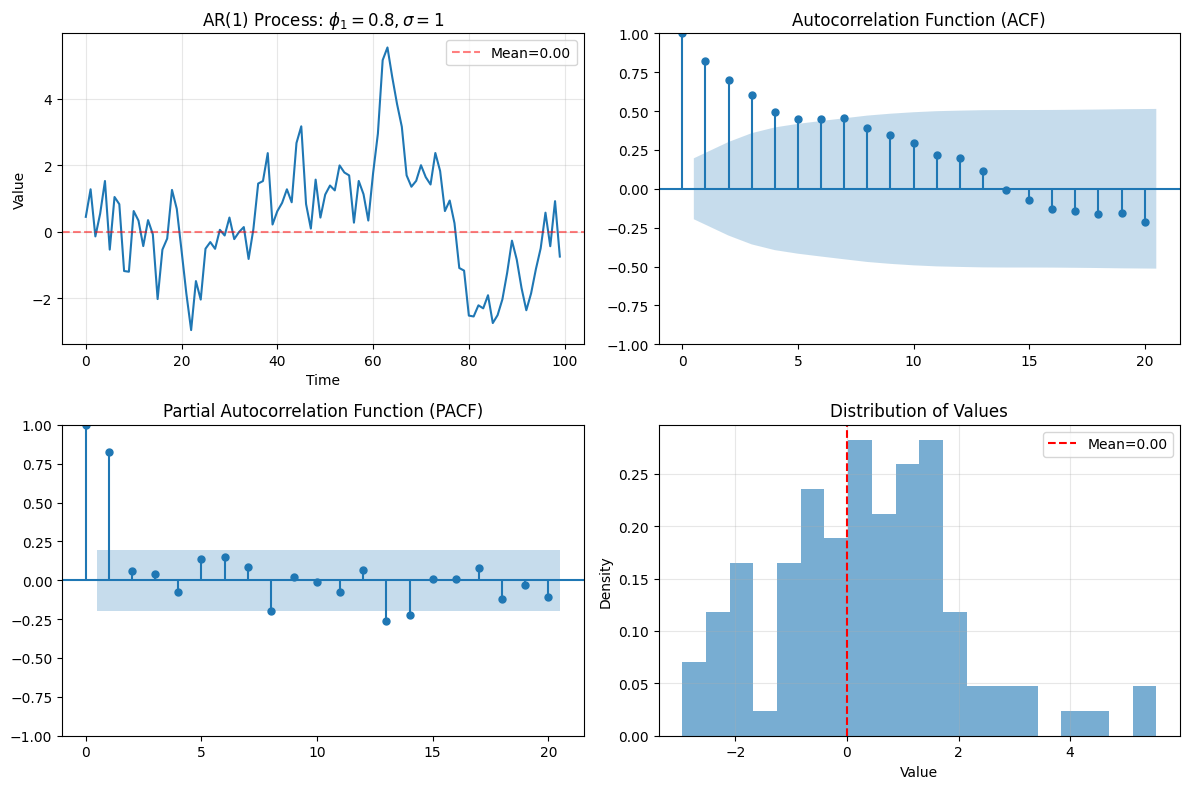

In [8]:
# Simulate AR(1) process with phi_0 = 0, phi_1 = 0.8, sigma = 1

# AR(1) parameters
phi_1 = 0.8  # AR coefficient
sigma = 1  # standard deviation of noise
n = 100

x = arma_generate_sample(ar=[1, -phi_1], ma=[1], nsample=n, scale=sigma)

# Plot the AR(1) process
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Time series plot

ax[0, 0].plot(x)
ax[0, 0].set_title(fr"AR(1) Process: $\phi_1 ={phi_1}, \sigma ={sigma}$")
ax[0, 0].axhline(0, color='red', linestyle='--', alpha=0.5, label=f'Mean={0:.2f}')
ax[0, 0].set_xlabel("Time")
ax[0, 0].set_ylabel("Value")
ax[0, 0].grid(alpha=0.3)
ax[0, 0].legend()

# ACF plot
plot_acf(x, lags=20, ax=ax[0, 1])
ax[0, 1].set_title("Autocorrelation Function (ACF)")

# PACF plot
plot_pacf(x, lags=20, ax=ax[1, 0])
ax[1, 0].set_title("Partial Autocorrelation Function (PACF)")

# Histogram
ax[1, 1].hist(x, bins=20, density=True, alpha=0.6)
ax[1, 1].set_title("Distribution of Values")
ax[1, 1].axvline(0, color='red', linestyle='--', label=f'Mean={0:.2f}')
ax[1, 1].set_xlabel("Value")
ax[1, 1].set_ylabel("Density")
ax[1, 1].legend()
ax[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## AR (2) Process

The AR(2) process is defined as:

$$
x_t = \phi_0 + \phi_1 x_{t-1} + \phi_2 x_{t-2} + e_t
$$

where the error term $e_t$ is white noise with mean zero and constant variance $\sigma^2$. For simplicity in the following example, we will set $\phi_0 = 0$ which implies that the mean of the process is zero (this is convenient for calculating the variance and covariances).

### Stationarity Conditions

A stochastic process is stationary if its statistical properties (mean, variance, autocovariance) do not change over time. We have already discussed the stability of second-order difference equations, which is a necessary condition for stationarity. We can derive the characteristic equation without referring to the vector autoregressive representation by looking at the lag-polynomial associated with the AR(2) process:

The lag-operator (back-shift operator) $B$ is defined as:

$$
\begin{align*}
B x_t &= x_{t-1} \\
B^2 x_t &= B(B x_t) = B x_{t-1} = x_{t-2}
\end{align*}
$$

We can rewrite the AR(2) process using the lag-operator:

$$
x_t = \phi_1 B x_t + \phi_2 B^2 x_t + e_t
$$

Rearranging terms, we get:

$$
(1 - \phi_1 B - \phi_2 B^2) x_t = e_t
$$

The characteristic equation is obtained by setting the lag-polynomial equal to zero and substituting $B$ with $1/\lambda$:

$$
1 - \phi_1 \lambda^{-1} - \phi_2 \lambda^{-2} = 0
$$

Now we can multiply through by $\lambda^2$ to get the standard form of the characteristic equation:

$$
\lambda^2 - \phi_1 \lambda - \phi_2 = 0
$$

The roots of this equation can be found using the quadratic formula:

$$
\lambda^{*}_{1,2} = \frac{\phi_1 \pm \sqrt{\phi_1^2 + 4 \phi_2}}{2}
$$

Exercise: are the processes with the following parameters stationary?

1. $\phi_1 = 0.5$, $\phi_2 = 0.2$
2. $\phi_1 = 0.8$, $\phi_2 = -0.8$

Use `np.roots` to compute the roots of the characteristic equation for different values of $\phi_1$ and $\phi_2$ and `np.abs` to check their magnitudes.

In [12]:
# The roots of the characteristic equation with phi_1 = 0.5 and phi_2 = 0.2 are

roots1 = np.roots([1, -0.5, -0.2])
print("Roots for phi_1 = 0.5, phi_2 = 0.2:", roots1)
print("Their magnitudes are", np.abs(roots1))

# For phi_1 = 1.2, phi_2 = -0.5

roots2 = np.roots([1, -0.8, 0.8])
print("Roots for phi_1 = 0.8, phi_2 = -0.8:", roots2)
print("Their magnitudes are", np.abs(roots2))


Roots for phi_1 = 0.5, phi_2 = 0.2: [ 0.76234754 -0.26234754]
Their magnitudes are [0.76234754 0.26234754]
Roots for phi_1 = 0.8, phi_2 = -0.8: [0.4+0.8j 0.4-0.8j]
Their magnitudes are [0.89442719 0.89442719]


## The Case of Complex Roots

As the last example shows, the roots of the characteristic equation can be complex numbers (if the order ot the autoregressive process is 2 or higher).

This can give rise to oscillatory behavior in the time series, which is sometimes observed in real-world data that exhibit cyclical patterns. Let's simulate an AR(2) process with complex roots, taking $\phi_1 = 0.8$ and $\phi_2 = -0.8$ as in the previous exercise.

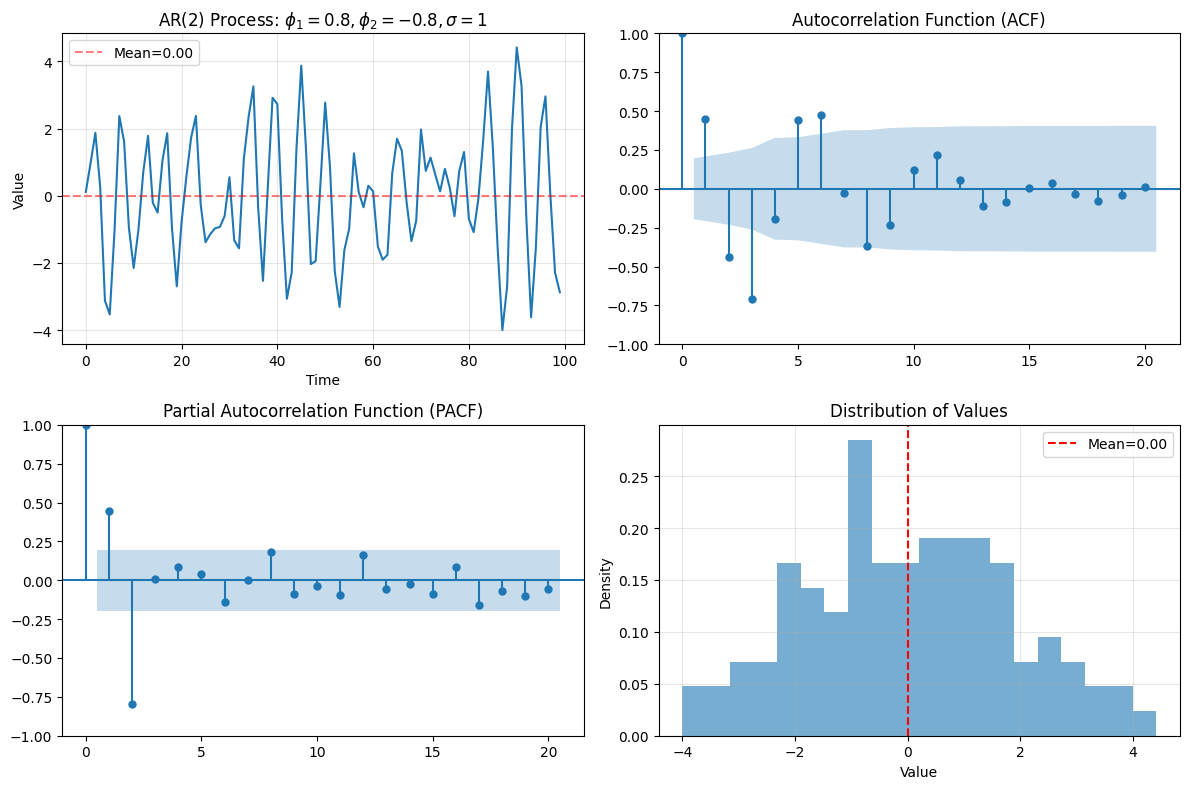

In [13]:
# Simulate AR(2) process with phi_0 = 0, phi_1 = 0.8, phi_2 = -0.8 and sigma = 1

# AR(1) parameters
phi_1 = 0.8  # AR coefficient
phi_2 = -0.8
sigma = 1  # standard deviation of noise
n = 100

x = arma_generate_sample(ar=[1, -phi_1, -phi_2], ma=[1], nsample=n, scale=sigma)

# Plot the AR(1) process
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Time series plot

ax[0, 0].plot(x)
ax[0, 0].set_title(fr"AR(2) Process: $\phi_1 ={phi_1}, \phi_2 = {phi_2}, \sigma ={sigma}$")
ax[0, 0].axhline(0, color='red', linestyle='--', alpha=0.5, label=f'Mean={0:.2f}')
ax[0, 0].set_xlabel("Time")
ax[0, 0].set_ylabel("Value")
ax[0, 0].grid(alpha=0.3)
ax[0, 0].legend()

# ACF plot
plot_acf(x, lags=20, ax=ax[0, 1])
ax[0, 1].set_title("Autocorrelation Function (ACF)")

# PACF plot
plot_pacf(x, lags=20, ax=ax[1, 0])
ax[1, 0].set_title("Partial Autocorrelation Function (PACF)")

# Histogram
ax[1, 1].hist(x, bins=20, density=True, alpha=0.6)
ax[1, 1].set_title("Distribution of Values")
ax[1, 1].axvline(0, color='red', linestyle='--', label=f'Mean={0:.2f}')
ax[1, 1].set_xlabel("Value")
ax[1, 1].set_ylabel("Density")
ax[1, 1].legend()
ax[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


### The Yule-Walker Equations

It is easiest to derive the Yule-Walker equations for an AR(2) process. Assuming that the mean of the process is zero (i.e., $\phi_0 = 0$), we can derive the variance and covariances by multiplying both sides of the AR(2) equation by $x_t$, $x_{t-1}$, and $x_{t-2}$ and taking expectations.

$$
\begin{align*}
\gamma(0) & = \phi_1 \gamma(1) + \phi_2 \gamma(2) + \sigma^2 \\
\gamma(1) & = \phi_1 \gamma(0) + \phi_2 \gamma(1) \\
\gamma(2) & = \phi_1 \gamma(1) + \phi_2 \gamma(0)
\end{align*}
$$

## The Partial Autocorrelation Function (PACF)

The partial autocorrelation function (PACF) measures the correlation between a time series and its lagged values, after removing the effects of intervening lags. In other words, it quantifies the direct relationship between $x_t$ and $x_{t-k}$, controlling for the influence of all intermediate lags ($x_{t-1}, x_{t-2}, ..., x_{t-(k-1)}$).

To see this, consider a regression model for 

$$
\text{income}_i = \beta_0 + \beta_1 \text{age}_{i} + \beta_2 \text{experience}_{i} + e_i 
$$

In [30]:
import pandas as pd

dt = pd.read_csv("https://raw.githubusercontent.com/febse/data/refs/heads/main/ts/multiple_linear_regression_dataset_age_income_experience.csv")
dt.head()

,age,experience,income
0,25,1,30450
1,30,3,35670
2,47,2,31580
3,32,5,40130
4,43,10,47830


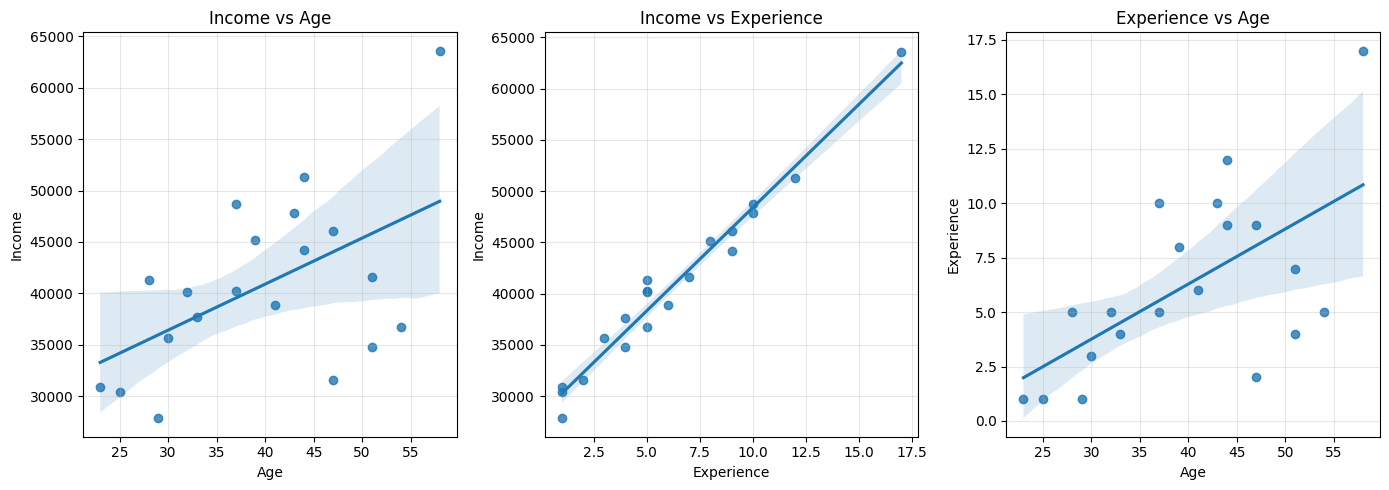

In [31]:
# Plot income vs age and experience with regression lines using seaborn
import seaborn as sns

fig, ax = plt.subplots(1, 3, figsize=(14, 5))

# Income vs Age
sns.regplot(x='age', y='income', data=dt, ax=ax[0])
ax[0].set_title("Income vs Age")
ax[0].set_xlabel("Age")
ax[0].set_ylabel("Income")
ax[0].grid(alpha=0.3)

# Income vs Experience
sns.regplot(x='experience', y='income', data=dt, ax=ax[1])
ax[1].set_title("Income vs Experience")
ax[1].set_xlabel("Experience")
ax[1].set_ylabel("Income")
ax[1].grid(alpha=0.3)

# Income vs Hours Worked
sns.regplot(x='age', y='experience', data=dt, ax=ax[2])
ax[2].set_title("Experience vs Age")
ax[2].set_xlabel("Age")
ax[2].set_ylabel("Experience")
ax[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [32]:
from pyexpat import model
from statsmodels.formula.api import ols

model_both = ols('income ~ age + experience', data=dt).fit()
print(model_both.params)


Intercept     31261.689854
age             -99.195355
experience     2162.404192
dtype: float64


In [42]:
model_income_experience = ols('income ~ experience', data=dt).fit()
print(model_income_experience.params)


Intercept     28248.446782
experience     2014.040842
dtype: float64


To calculate the partial correlation between income and experience, controlling for age, we
regress income on age and compute the residuals. We then regress experience on age and compute the residuals. Finally, we calculate the correlation between the two sets of residuals. This correlation is the partial correlation between income and experience, controlling for age.

In [43]:
model_experience_age = ols('age ~ experience', data=dt).fit()
print(model_experience_age.params)

Intercept     30.376856
experience     1.495668
dtype: float64


In [46]:
# The correlation coefficient between income and age

np.corrcoef(dt["income"], dt["age"])

array([[1.        , 0.53220434],
       [0.53220434, 1.        ]])

In [ ]:
# The partial correlation coefficient between income and age controlling for experience

np.corrcoef(model_income_experience.resid, model_experience_age.resid)

array([[ 1.        , -0.52523009],
       [-0.52523009,  1.        ]])

In [47]:
model_income_experience.resid

0      187.512376
1     1379.430693
2     -696.528465
3     1811.349010
4     -558.855198
5     -716.732673
6     3021.349010
7     1345.389851
8     1931.349010
9      789.226485
10   -2422.487624
11    -264.814356
12   -1598.650990
13   -1504.610149
14   -1116.936881
15   -1432.691832
16    1112.858911
17     607.512376
18   -2184.814356
19     311.144802
dtype: float64

## Moving Average (MA) Processes

A simple moving average process of order $q$, denoted as MA(q), is defined as:

$$
x_t = e_t + \theta_1 e_{t-1} + \theta_2 e_{t-2} + ... + \theta_q e_{t-q}
$$

where:
- $x_t$ is the value of the time series at time $t$.
- $e_t$ is a white noise error term at time $t$.
- $\theta_1, \theta_2, ..., \theta_q$ are the parameters of the model.

The moving average process of order 1 only includes the immediate past error term:

$$
x_t = e_t + \theta_1 e_{t-1}
$$

The expected value of this process is zero, because it is a linear combination of white noise terms, each of which has an expected value of zero.

$$
E(x_t) = E(e_t) + \theta_1 E(e_{t-1}) = 0 + \theta_1 \cdot 0 = 0
$$

We can calculate its variance by using the result that its mean is zero (see above). 

$$
\begin{align*}
Var(x_t) & = E(x_t^2) \\
         & = E\left((e_t + \theta_1 e_{t-1})^2\right) \\
         & = E\left(e_t^2 + 2\theta_1 e_t e_{t-1} + \theta_1^2 e_{t-1}^2\right) \\
         & = E(e_t^2) + 2\theta_1 E(e_t e_{t-1}) + \theta_1^2 E(e_{t-1}^2) \\        
         & = \sigma^2 + 2\theta_1 \cdot 0 + \theta_1^2 \sigma^2 \\
         & = (1 + \theta_1^2) \sigma^2
\end{align*}
$$

Its autocovariance function (ACF) at lag $k = 1$ is given by:

$$
\begin{align*}
\gamma(1) & = Cov(x_t, x_{t-1}) \\
          & = E\left[(x_t - E(x_t))(x_{t-1} - E(x_{t-1}))\right] \\
          & = E(x_t x_{t-1}) \\
          & = E\left[(e_t + \theta_1 e_{t-1})(e_{t-1} + \theta_1 e_{t-2})\right] \\
          & = E\left[e_t e_{t-1} + \theta_1 e_t e_{t-2} + \theta_1 e_{t-1}^2 + \theta_1^2 e_{t-1} e_{t-2}\right] \\
          & = 0 + \theta_1 \cdot 0 + \theta_1 \sigma^2 + \theta_1^2 \cdot 0 \\
          & = \theta_1 \sigma^2
\end{align*}
$$

Its autocovariance function (ACF) at lag $k > 1$ is zero, see for example lag $k = 2$ below:

$$
\begin{align*}
\gamma(2) & = E(x_t x_{t-2}) \\
          & =  E\left[(e_t + \theta_1 e_{t-1})(e_{t-1} + \theta_1 e_{t-2})\right] \\
          & = E\left[e_t e_{t-2} + \theta_1 e_{t-1} e_{t-2} + \theta_1 e_t e_{t-1} + \theta_1^2 e_{t-1} e_{t-2}\right] \\
          & = 0 + \theta_1 \cdot 0 + \theta_1 \cdot 0 + \theta_1^2 \cdot 0 \\
          & = 0
\end{align*}          
$$


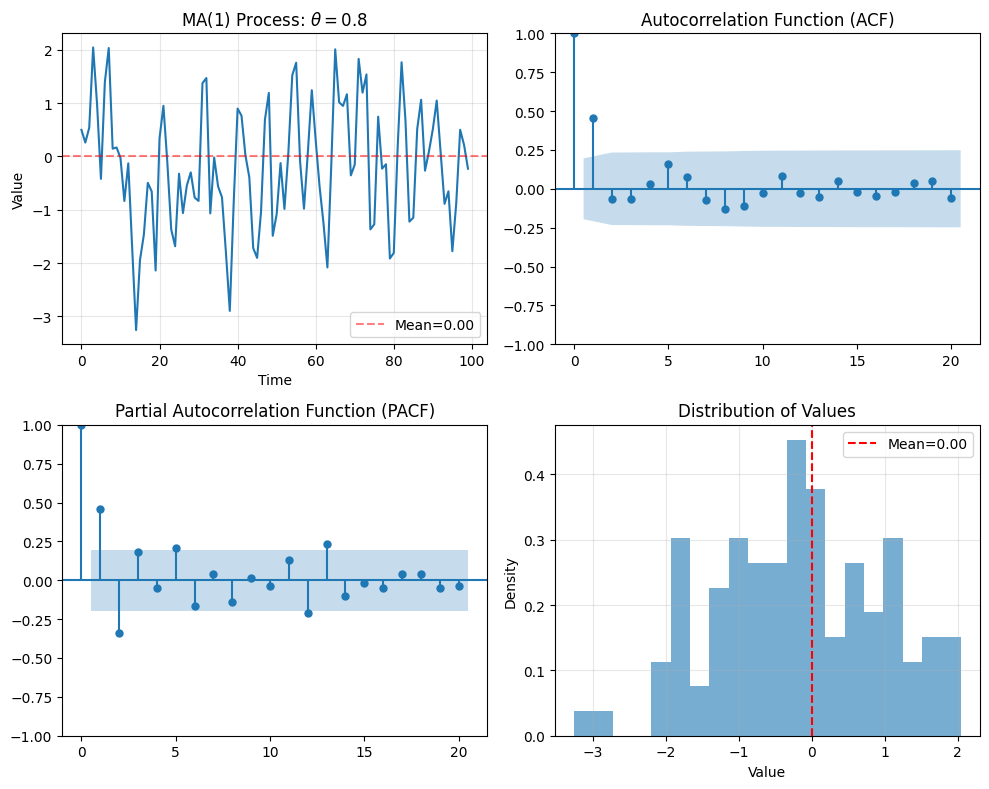

In [52]:
# Simulate MA(1) process with theta = 0.8, sigma = 1

from statsmodels.tsa.arima_process import arma_generate_sample

np.random.seed(42)

# MA(1) parameters
theta = 0.8
n = 100

# Generate MA(1) sample
x = arma_generate_sample(ar=[1], ma=[1, theta], nsample=n, scale=1)

# Plot the MA(1) process
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

# Time series plot
ax[0, 0].plot(x)
ax[0, 0].set_title(fr"MA(1) Process: $\theta ={theta}$")
ax[0, 0].axhline(0, color='red', linestyle='--', alpha=0.5, label=f'Mean={0:.2f}')
ax[0, 0].set_xlabel("Time")
ax[0, 0].set_ylabel("Value")
ax[0, 0].grid(alpha=0.3)
ax[0, 0].legend()

# ACF plot

plot_acf(x, lags=20, ax=ax[0, 1])
ax[0, 1].set_title("Autocorrelation Function (ACF)")

# PACF plot
plot_pacf(x, lags=20, ax=ax[1, 0])
ax[1, 0].set_title("Partial Autocorrelation Function (PACF)")
# Histogram
ax[1, 1].hist(x, bins=20, density=True, alpha=0.6)
ax[1, 1].set_title("Distribution of Values")
ax[1, 1].axvline(0, color='red', linestyle='--', label=f'Mean={0:.2f}')
ax[1, 1].set_xlabel("Value")
ax[1, 1].set_ylabel("Density")
ax[1, 1].legend()
ax[1, 1].grid(alpha=0.3)
plt.tight_layout()
plt.show()